# SPIT Version 1
SPIT stands for **SP**arse **I**ndex Expansion with **T**ransformers

This notebook takes a DistilBert model from the Huggingface Transformers library and adds a classification layer to the output of the CLS token.
* DeepCT uses mean squared error as a loss function. None of the out-of-the-box Huggingface models use this loss function, so we'll have to add out own layer to the base model.
* Distilbert is a slimmed down version of BERT that requires less memory.
* We're using Distilbert while we're debugging the training pipeline because it reqires fewer resources.

In [1]:
import json
import os

import numpy as np
import sklearn.model_selection
import tensorflow as tf
import transformers

## 1. Import base Distilbert model from Huggingface Transformers

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'vocab_layer_norm', 'vocab_transform', 'activation_13']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "tf_distil_bert_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
distilbert (TFDistilBertMain multiple                  66362880  
Total params: 66,362,880
Trainable params: 0
Non-trainable params: 66,362,880
_________________________________________________________________
None


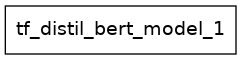

In [62]:
# For train-test splits and initialization of weights.
random_state=210

# Import model and tokenizer
model_name = 'distilbert-base-uncased'
tokenizer = transformers.DistilBertTokenizerFast.from_pretrained(model_name)
config = transformers.DistilBertConfig(output_hidden_states=True)
model = transformers.TFDistilBertModel.from_pretrained(model_name,
                                                       config=config)

# Freeze the pre-trained Distilbert weights, at least for now.
for layer in model.layers:
    layer.trainable = False
    
print(model.summary())
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True, expand_nested=True)

## 2. Get Some Data
The `myalltrain.relevant.docterm_recall` file contains training data from the DeepCT repository. The data consists of passages (`['doc']['title']`) and terms (`['term_recall']` that are known to be important.

In [5]:
# Example lines from file
data_path = 'myalltrain.relevant.docterm_recall'
with open(data_path, 'rt') as dfile:
    for _ in range(3):
        print(dfile.readline())

{"query": "what kind of animals are in grasslands", "term_recall": {"grassland": 1, "animals": 1}, "doc": {"position": "1", "id": "4083643", "title": "Tropical grassland animals (which do not all occur in the same area) include giraffes, zebras, buffaloes, kangaroos, mice, moles, gophers, ground squirrels, snakes, worms, termites, beetles, lions, leopards, hyenas, and elephants."}}

{"query": "what cause shin splints", "term_recall": {"caused": 1, "splints": 1, "shin": 1}, "doc": {"position": "1", "id": "1773684", "title": "Shin splints, also known as medial tibial stress syndrome (MTSS), is defined by the American Academy of Orthopaedic Surgeons as pain along the inner edge of the shinbone (tibia).. Shin splints are usually caused by repeated trauma to the connective muscle tissue surrounding the tibia."}}

{"query": "what type of deficiency is caused by inadequate absorption of a nutrient?", "term_recall": {"absorption": 1, "nutrients": 1, "deficiency": 1, "caused": 1, "inadequate": 

In [6]:
def read_data_file(path, max_rows=None):
    """Extracts terms and passages from data file."""
    data = []
    with open(path, 'rt') as dfile:
        row_num = 0
        for line_txt in dfile:
            line_data = json.loads(line_txt)
            for term in line_data['term_recall']:
                data.append((term, line_data['doc']['title']))
            
            row_num += 1
            if max_rows is not None and row_num >= max_rows:
                break
    print('Rows read:', row_num)
    return data

In [63]:
# Read top 1000 rows from data file.
data = read_data_file(data_path, max_rows=1000)

Rows read: 1000


## 3. Split into Train, Dev, and Test Data

In [8]:
train_data, testdev_data = sklearn.model_selection.train_test_split(
    data,
    test_size=0.4,
    random_state = random_state)
print('Number training records:', len(train_data))
print('Number test/dev records:', len(testdev_data))

Number training records: 1681
Number test/dev records: 1122


In [9]:
dev_data, test_data = sklearn.model_selection.train_test_split(
    testdev_data,
    test_size=0.5,
    random_state = random_state)

print('Number dev records:', len(dev_data))
print('Number test records:', len(test_data))

Number dev records: 561
Number test records: 561


## 4. Create Labels
Due to the source of this data, all candidate terms are relevant. We'll need to figure out how to add irrelevant terms for actual testing.

In [10]:
train_labels = np.ones(len(train_data))
dev_labels = np.ones(len(dev_data))
test_labels = np.ones(len(test_data))

## 5. Convert Text to WordPiece Encodings and Create a Dataset

In [11]:
train_encodings = tokenizer(train_data, truncation='only_second', padding='max_length')
dev_encodings = tokenizer(dev_data, truncation='only_second', padding='max_length')
test_encodings = tokenizer(test_data, truncation='only_second', padding='max_length')

In [12]:
print('ids:', train_encodings[0].ids[:10])
print('Tokens:', train_encodings[0].tokens[:10])
train_encodings[0].type_ids[:10]

ids: [101, 8116, 102, 2190, 3437, 1024, 1037, 3528, 1997, 2111]
Tokens: ['[CLS]', 'deliver', '[SEP]', 'best', 'answer', ':', 'a', 'variety', 'of', 'people']


[0, 0, 0, 1, 1, 1, 1, 1, 1, 1]

In [13]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
))

In [64]:
# Check out format of encodings object.
e0 = train_encodings[0]
e0

Encoding(num_tokens=512, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])

## 6. Test Base Distilbert Model
Obviously we've done no fine tuning. But it's helpful to verify that Distilbert accepts our data as input and produces an output of the appropriate shape.

In [17]:
preds = model.predict(train_dataset.take(1), 1)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


The output shape is as expected -- a secquence of 512 vectors, each vector having 768 elements.

In [18]:
preds.last_hidden_state.shape

(512, 1, 768)

## 7. Add Classification Layer to End of Distilbert Model

First, we must re-specify the shape of our input data.

In [19]:
max_len = 512
input_ids_layer = tf.keras.layers.Input(shape=(max_len,),
                                       name='input_ids',
                                       dtype='int32')

input_attention_layer = tf.keras.layers.Input(shape=(max_len,), 
                                                  name='input_attention', 
                                                  dtype='int32')

Next we extract the hidden state for only the CLS token.

In [37]:
cls_token = model(input_ids=input_ids_layer, attention_mask=input_attention_layer).last_hidden_state[:, 0, :]

The class token output checks out -- it's a single vector of 768 elements.

In [38]:
cls_token

<KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'tf.__operators__.getitem_6')>

Next, create a dense layer with a single output.
* **TODO**: Check what activation, if any, is used by DeepCT. It's probably not sigmoid.
* **TODO**: Look into other kernal initialization options.

In [39]:
weight_initializer = tf.keras.initializers.GlorotNormal(seed=random_state) 
output = tf.keras.layers.Dense(1, 
                               activation='sigmoid',
                               kernel_initializer=weight_initializer,  
                               kernel_constraint=None,
                               bias_initializer='zeros'
                               )(cls_token)

Create and compile the model

In [65]:
spit = tf.keras.Model([input_ids_layer, input_attention_layer], output)
LEARNING_RATE = 5e-5
spit.compile(tf.keras.optimizers.Adam(lr=LEARNING_RATE), 
                  loss=tf.keras.losses.MeanSquaredError(),
                  metrics=['accuracy'])

In [43]:
spit.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_attention (InputLayer)    [(None, 512)]        0                                            
__________________________________________________________________________________________________
tf_distil_bert_model (TFDistilB TFBaseModelOutput(la 66362880    input_ids[0][0]                  
                                                                 input_attention[0][0]            
__________________________________________________________________________________________________
tf.__operators__.getitem_6 (Sli (None, 768)          0           tf_distil_bert_model[9][7]   

## 8. Test Modified Model

Adding the additional layer changed how the model accepts input. We must now pass in the token IDs and attention mask as a list of tensors.

In [71]:
def convert_list_to_tensor(lst):
    return tf.expand_dims(tf.convert_to_tensor(lst, dtype='int32'), axis=0)

In [72]:
preds2 = spit.predict([convert_list_to_tensor(train_encodings[0].ids),
                      convert_list_to_tensor(train_encodings[0].attention_mask)], 1)
preds2

array([[0.61314005]], dtype=float32)